In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
sys.path.append('../utils')
import Aircraft3dofModel
import FinaltimeFreeCost
import Aircraft3dofConstraints
from scipy.integrate import solve_ivp
from SCP_buffer_deviation import SCP_buffer_deviation
from Scaling import TrajectoryScaling

In [124]:
ix = 6
iu = 3
tf = 600
N = 50
delT = tf/N
max_iter = 50

In [125]:
myModel = Aircraft3dofModel.Aircraft3dof('Hello',ix,iu,linearization="analytic")
myCost = FinaltimeFreeCost.Finaltime('Hello',ix,iu,N)
myConst = Aircraft3dofConstraints.Aircraft3dof('Hello',ix,iu)

x_min = np.zeros(ix)
x_max = np.array([110*1e3,60*1e3,10*1e3,240,np.deg2rad(20),np.pi/2])
u_min = np.array([0,0,0])
u_max = np.array([1.52,np.deg2rad(15),1126.3 * 1e3]) 

myScaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [126]:
xi = np.array([0*1e3,0*1e3,10*1e3,240,0,0])
xf = np.array([110*1e3,-60*1e3,0,95,-np.deg2rad(3),np.deg2rad(80)])
# xf = np.array([110*1e3,-0*1e3,0,95,-np.deg2rad(0),np.deg2rad(0)])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf

u0 = np.zeros((N+1,iu))
ui = np.array([0.5,np.deg2rad(15),0])
uf = np.array([0.5,-np.deg2rad(-15),0])
for i in range(N+1) :
    u0[i] = (N-i)/N * ui + i/N * uf
idx_c = int(26 * N / 50)
for i in range(0,idx_c+1) :
    u0[i,0] = (idx_c-i)/idx_c * 0.3 + i/idx_c * 0.15
for i in range(idx_c+1,N+1) :
    u0[i,0] = 1/700* (i-idx_c-1)**2 + 0.15

In [141]:
# w_tr for time is 1
i1 = SCP_buffer_deviation('hello',N,tf,max_iter,myModel,myCost,myConst,myScaling,
          type_discretization="foh",w_c=1e-2,w_bf=1e4,w_bf_b=1e4,w_tr=1e2,tol_bf=1e-6,tol_tr=1e-6)
x,u,xbar,ubar,Tbar,total_num_iter,flag_boundary,l,l_vc,l_tr,x_traj,u_traj  = i1.run(x0,u0,xi,xf)



iteration   total_cost        cost        ||bf||     ||tr||       reduction   w_tr        bounary
1           50415.744         5.00000     1.67        337         -4.98e+04   100.000000  0(9.1e+04)
non-positive expected reduction
2           51760.823         5.02309     2.11        306         -1.35e+03   100.000000  0(1.44e+05)
3           19241.661         4.82309     0.577       135         3.25e+04    100.000000  0(9.74e+04)
4           12970.725         5.23792     0.298       99.8        6.27e+03    100.000000  0(8.15e+04)
5           1241.478          5.73958     0.0157      10.8        1.17e+04    100.000000  0(1.22e+04)
6           35.655            6.26615     0.000145    0.279       1.21e+03    100.000000  0(1.33e+03)
7           7.321             6.27631     6.15e-06    0.00983     28.3        100.000000  0(89.9)
8           6.287             6.26823     1.17e-07    0.000176    1.03        100.000000  0(86.4)
9           6.264             6.25831     5.59e-09    5.22e-05 

In [146]:
print(np.sum(Tbar))

597.5133680004792


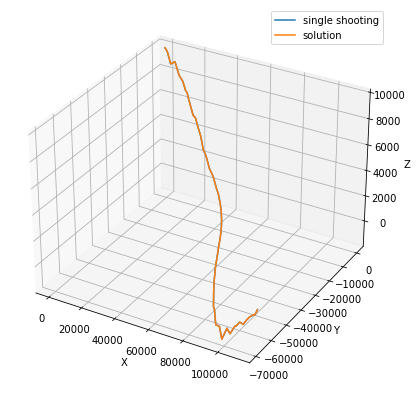

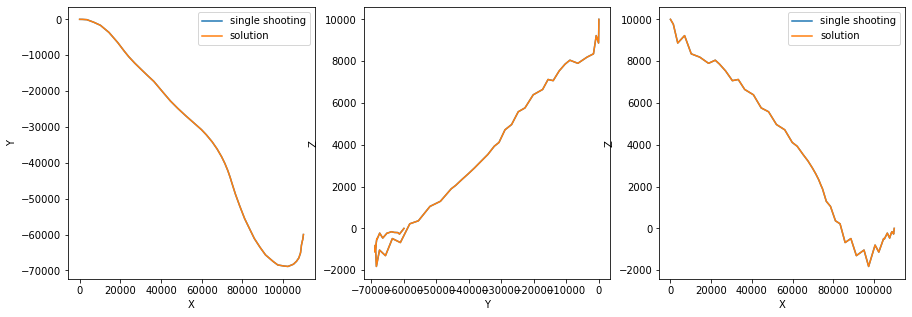

In [147]:
t_index = [np.sum(Tbar[:i])  for i in range(N+1)]
fig = plt.figure(1,figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot(x[:, 0], x[:, 1], x[:, 2],label='single shooting')
ax.plot(xbar[:, 0], xbar[:, 1], xbar[:, 2],label='solution')
plt.legend()
fig = plt.figure(2,figsize=(15,5))
ax = fig.add_subplot(131)
ax.plot(x[:, 0], x[:, 1],label='single shooting')
ax.plot(xbar[:, 0], xbar[:, 1],label='solution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.legend()
ax = fig.add_subplot(132)
ax.plot(x[:, 1], x[:, 2],label='single shooting')
ax.plot(xbar[:, 1], xbar[:, 2],label='solution')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax = fig.add_subplot(133)
ax.plot(x[:, 0], x[:, 2],label='single shooting')
ax.plot(xbar[:, 0], xbar[:, 2],label='solution')
ax.set_xlabel('X')
ax.set_ylabel('Z')
plt.legend()
# ax.plot(xbar[:, 0], xbar[:, 1], xbar[:, 2],'o')

In [148]:
np.abs(x[-1] - xbar[-1])

array([8.01428655e-01, 1.53818066e+00, 1.85871652e-02, 1.47634551e-04,
       9.53467678e-06, 1.55126863e-05])

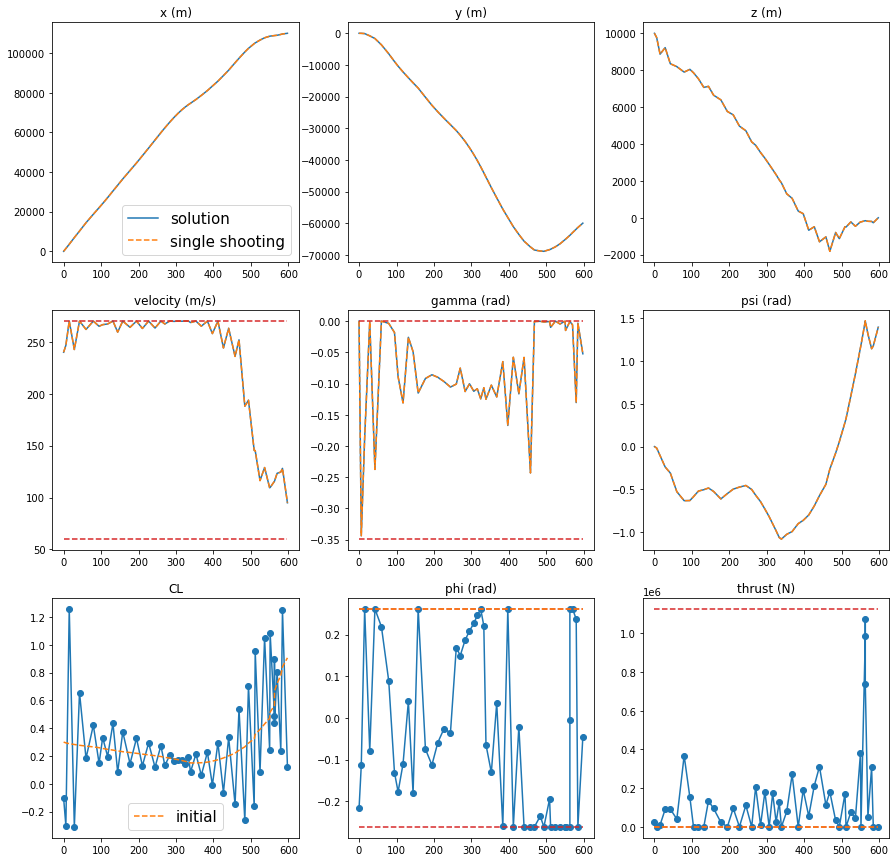

In [149]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.plot(t_index,xbar[:,0],label='solution')
plt.plot(t_index,x[:,0],'--',label='single shooting')
plt.legend(fontsize=15)
plt.title('x (m)')

plt.subplot(332)
plt.plot(t_index,xbar[:,1])
plt.plot(t_index,x[:,1],'--')
plt.title('y (m)')

plt.subplot(333)
plt.plot(t_index,xbar[:,2])
plt.plot(t_index,x[:,2],'--')
plt.title('z (m)')


plt.subplot(334)
plt.plot(t_index,xbar[:,3])
plt.plot(t_index,x[:,3],'--')
plt.plot(t_index,ubar[:,2]*0 + myConst.v_max,'--',color='tab:red')
plt.plot(t_index,ubar[:,2]*0 + myConst.v_min,'--',color='tab:red')
plt.title('velocity (m/s)')

plt.subplot(335)
plt.plot(t_index,xbar[:,4])
plt.plot(t_index,x[:,4],'--')
plt.plot(t_index,ubar[:,2]*0 + myConst.gamma_max,'--',color='tab:red')
plt.plot(t_index,ubar[:,2]*0 + myConst.gamma_min,'--',color='tab:red')
plt.title('gamma (rad)')

plt.subplot(336)
plt.plot(t_index,xbar[:,5])
plt.plot(t_index,x[:,5],'--')
plt.title('psi (rad)')

plt.subplot(337)
plt.plot(t_index,ubar[:,0],'o-')
# plt.plot(t_index,ubar[:,2]*0 + myConst.CL_max,'--',color='tab:red')
# plt.plot(t_index,ubar[:,2]*0 + myConst.CL_min,'--',color='tab:red')
plt.title('CL')
plt.plot(t_index,u0[:,0],'--',label='initial')
plt.legend(fontsize=15)
plt.subplot(338)
plt.plot(t_index,ubar[:,1],'o-')
plt.plot(t_index,ubar[:,2]*0 + myConst.phi_max,'--',color='tab:red')
plt.plot(t_index,ubar[:,2]*0 + myConst.phi_min,'--',color='tab:red')
plt.title('phi (rad)')
plt.plot(t_index,u0[:,1],'--',label='initial')
plt.subplot(339)
plt.plot(t_index,ubar[:,2],'o-')
plt.plot(t_index,ubar[:,2]*0 + myConst.T_max,'--',color='tab:red')
plt.plot(t_index,ubar[:,2]*0 + myConst.T_min,'--',color='tab:red')
plt.title('thrust (N)')
plt.plot(t_index,u0[:,2],'--',label='initial')

In [ ]:
T = 15.04 - 0.00649 * xbar[:,2] # celsius
p = 101.29 * np.power((T+273.1)/288.08,5.256)
rho = p / (0.2869 * (T + 273.1))

F_lift = 0.5 * rho * xbar[:,3] * xbar[:,3] * myModel.Sw * ubar[:,0]
F_draf = 0.5 * rho * xbar[:,3] * xbar[:,3] * myModel.Sw * (myModel.CD0 + myModel.K  * ubar[:,0] * ubar[:,0])

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(t_index,rho)

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(338)
plt.plot(t_index,F_lift)
plt.title('Lift force (N)')

plt.subplot(339)
plt.plot(t_index,F_draf)
plt.title('Drag force (N)')

In [ ]:
for ubar_ in u_traj :
    plt.plot(t_index,ubar_[:,2],alpha=0.5,color='tab:blue')
# plt.title('CL')

In [ ]:
a = np.random.randn(3,2,3)
print(a)
print()
b = np.array([1,2,3])
print((a.T*b).T)